## 데이터 준비

In [1]:
import pandas as pd

|    코드   |    의미                    |    창업 관점에서 적절한 점수    |
| -- | --------------------- | -------------- |
|    LH    | 신규 창업에 유리한 환경         | **4 (가장 유리)**  |
|    HL    | 기존 업체에 유리 → 창업은 다소 신중 | **3**          |
|    HH    | 진입 장벽 높음, 경쟁 심함       | **2**          |
|    LL    | 불안정, 도시재생 중 → 리스크 큼   | **1 (가장 낮음)**  |

In [2]:
df_total = pd.read_csv("./data/변수 통합_original.csv")
df_total.head()

,자치구,인구밀도,교통 편의성,문화 인프라 지수,예술인프라지수,의료 인프라 지수,상권_변화_지표,성장가능성
0,종로구,6292.471769,0.414197,0.320997,0.000386,0.569375,HH,2
1,중구,13232.228916,0.448910,1.059722,0.000152,0.883985,HH,2
2,용산구,10384.362140,0.254171,0.061350,0.000053,0.067072,HH,2
3,성동구,16930.202140,0.375717,0.005239,0.000014,0.119998,LH,4
4,광진구,20584.994138,0.236879,0.015377,0.000009,0.114405,LL,1


In [3]:
df_total.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   자치구        25 non-null     object 
 1   인구밀도       25 non-null     float64
 2   교통 편의성     25 non-null     float64
 3   문화 인프라 지수  24 non-null     float64
 4   예술인프라지수    25 non-null     float64
 5   의료 인프라 지수  25 non-null     float64
 6   상권_변화_지표   25 non-null     object 
 7   성장가능성      25 non-null     int64  
dtypes: float64(5), int64(1), object(2)
memory usage: 1.7+ KB


In [14]:
df = df_total.copy()

### 

### 회귀분석

In [15]:
from statsmodels.formula.api import ols, glm

# 공백이 있는 컬럼명 처리
df = df.rename(columns={
    '교통 편의성': '교통_편의성',
    '예술인프라지수': '예술인프라지수',
    '의료 인프라 지수': '의료_인프라_지수',
    '인구밀도': '인구밀도',
    '성장가능성': '성장가능성'
})

# 회귀 분석
Rformula = '성장가능성 ~ 인구밀도 + 교통_편의성 + 예술인프라지수 + 의료_인프라_지수'
regression_result = ols(Rformula, data=df).fit()
regression_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  성장가능성   R-squared:                       0.152
Model:                            OLS   Adj. R-squared:                 -0.017
Method:                 Least Squares   F-statistic:                    0.8995
Date:                Tue, 17 Jun 2025   Prob (F-statistic):              0.483
Time:                        01:47:07   Log-Likelihood:                -33.896
No. Observations:                  25   AIC:                             77.79
Df Residuals:                      20   BIC:                             83.89
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2449      1.262      0.194      0.848      -2.388       2.877
인구밀도        4.971e-05   5.76e-05      0.864      0.398   -7.03e-05       0.000
교통_편의성         2.1143      1.354      1.561      0.134      -0.711       4.940
예술인프라지수     5086.2889   3575.933      1.422      0.170   -2372.977    1.25e+04
의료_인프라_지수     -1.4450      1.121     -1.289      0.212      -3.783       0.893
==============================================================================
Omnibus:                        5.426   Durbin-Watson:                   2.464
Prob(Omnibus):                  0.066   Jarque-Bera (JB):                4.220
Skew:                           1.005   Prob(JB):                        0.121
Kurtosis:                       3.106   Cond. No.                     2.96e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.96e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<b>결과:</b>  
- R-squared가 1에 가까울수록 회귀모델이 데이터에 잘 들어맞는 것이지만  
  위 모델은 0.152로 **데이터에 맞지 않음을 확인할 수 있다.**  
- 또한 모든 변수에 대한 P-value가 0.05보다 훨씬 크므로  
  **모든 변수가 통계적으로 유의하지 않음**을 알 수 있다.
   
=> 순서혈 로지스틱 회귀 분석 수행

### 

### 로지스틱 회귀

In [8]:
from sklearn.preprocessing import StandardScaler
from mord import LogisticAT

# 🔹 1. X, y 정의
X_cols = ['인구밀도', '교통_편의성', '예술인프라지수', '의료_인프라_지수']
X = df[X_cols]
y = df['성장가능성']

# 🔹 2. 표준화
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 🔹 3. 순서형 로지스틱 회귀 모델 훈련
model = LogisticAT()  # LogisticAT = proportional odds model
model.fit(X_scaled, y)

# 🔹 4. 예측 (선택)
y_pred = model.predict(X_scaled)

# 🔹 5. 결과 확인
from sklearn.metrics import classification_report, confusion_matrix
print("분류 리포트:\n", classification_report(y, y_pred))
print("혼동 행렬:\n", confusion_matrix(y, y_pred))

분류 리포트:
               precision    recall  f1-score   support

           1       0.57      0.62      0.59        13
           2       0.20      0.29      0.24         7
           3       1.00      0.50      0.67         2
           4       0.00      0.00      0.00         3

    accuracy                           0.44        25
   macro avg       0.44      0.35      0.37        25
weighted avg       0.43      0.44      0.43        25

혼동 행렬:
 [[8 5 0 0]
 [5 2 0 0]
 [0 1 1 0]
 [1 2 0 0]]


C:\venvs\py37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\venvs\py37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\venvs\py37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<b>정확도(accuracy): 0.44</b>  
총 25개 샘플 중 11개를 정확히 맞춤.  
클래스 수(4개) 대비 baseline이 약 25%인 점을 고려하면 조금 나은 수준이지만, 신뢰할 정도로 높지는 않음.
  
| 성장가능성 | Precision | Recall | F1-score | Support | 해석                  |
| ----- | --------- | ------ | -------- | ------- | ------------------- |
| 1     | 0.57      | 0.62   | 0.59     | 13      | 수가 많고 비교적 안정적으로 예측  |
| 2     | 0.20      | 0.29   | 0.24     | 7       | 예측 정확도 낮고 혼동 많음     |
| 3     | 1.00      | 0.50   | 0.67     | 2       | 예측 대상 적어 신뢰도 낮음     |
| 4     | 0.00      | 0.00   | 0.00     | 3       | 전혀 예측 못함 (Recall 0) |



### 

### DBSCCAN 군집 분석

In [11]:
# 시각화 준비
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# 경고 무시
warnings.filterwarnings("ignore")

# 한글 폰트 설정 (윈도우 기준)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False


 0    14
-1     7
 1     2
 2     2
Name: dbscan_cluster, dtype: int64


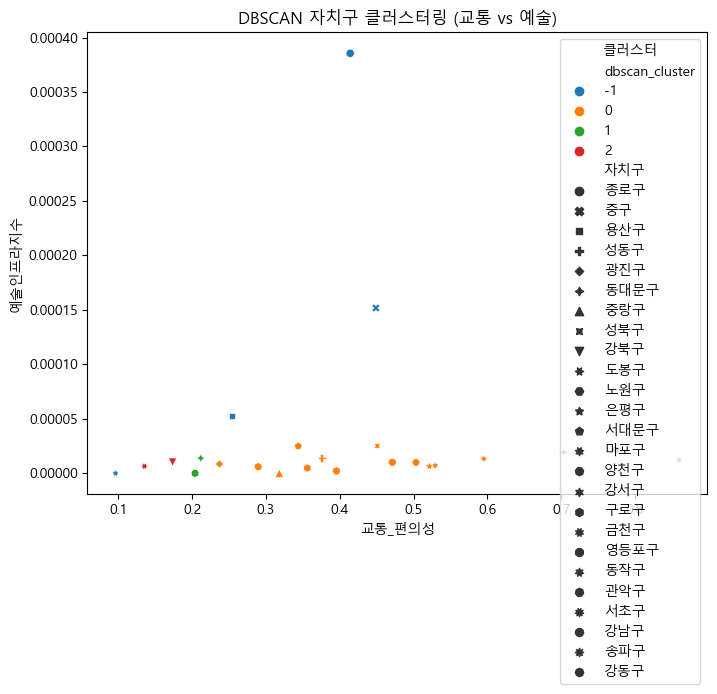

In [12]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# 이미 위 코드에서 표준화 진행함
# # 1. 표준화
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(df[numeric_cols])

# 2. DBSCAN
dbscan = DBSCAN(eps=0.8, min_samples=2)  # eps와 min_samples는 조정 가능
df['dbscan_cluster'] = dbscan.fit_predict(X_scaled)

# 3. 군집 결과 확인
print(df['dbscan_cluster'].value_counts())  # -1은 노이즈로 분류된 샘플

# 4. 시각화 (교통 vs 예술)
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='교통_편의성', y='예술인프라지수', hue='dbscan_cluster', palette='tab10', style='자치구')
plt.title('DBSCAN 자치구 클러스터링 (교통 vs 예술)')
plt.legend(title='클러스터')
plt.show()
